In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [ ]:
!pip install wget --quiet
!pip install --upgrade diffusers huggingface_hub gradio transformers

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, AutoConfig
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionInpaintPipeline

import base64, os
import wget
from shutil import copyfile
import shutil
from google.colab import files
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from torchvision.transforms import functional as F

In [ ]:
# load Mask2Former fine-tuned on COCO panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/82.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/866M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

In [ ]:
# Load the configuration for the Mask2Former model
config = AutoConfig.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

# print the id2label and label2id
print("id2label:", config.id2label)
print("label2id:", config.label2id)

id2label: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 6

In [ ]:
# Function to upload an image or download from URL
def get_image():
    user_choice = input("Do you want to upload an image (up) or provide a URL (url)? ").upper()

    if user_choice == "UP":
        # Upload an image
        from google.colab import files
        uploaded = files.upload()
        img = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
    elif user_choice == "URL":
        # Download from URL
        url = input("Enter the image URL: ")
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    else:
        print("Invalid choice. Please enter 'up' for upload or 'url' for URL.")
        img = None

    return img

# Get the image
image = get_image()

# Ensure the image is of type PIL.Image.Image
if not isinstance(image, Image.Image):
    print("Converting image to PIL.Image.Image format.")
    image = Image.fromarray(np.array(image))

# Process the image with the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[(image.size[0], image.size[1])])[0]

predicted_panoptic_map = result["segmentation"]

result

Do you want to upload an image (up) or provide a URL (url)? up


Saving people in park.jpg to people in park.jpg


`label_ids_to_fuse` unset. No instance will be fused.


{'segmentation': tensor([[4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 13,
   'was_fused': False,
   'score': 0.998937},
  {'id': 2, 'label_id': 0, 'was_fused': False, 'score': 0.999765},
  {'id': 3, 'label_id': 126, 'was_fused': False, 'score': 0.841902},
  {'id': 4, 'label_id': 116, 'was_fused': False, 'score': 0.998347},
  {'id': 5, 'label_id': 125, 'was_fused': False, 'score': 0.995866},
  {'id': 6, 'label_id': 0, 'was_fused': False, 'score': 0.999755}]}

<ipython-input-10-4189175089>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_ids))


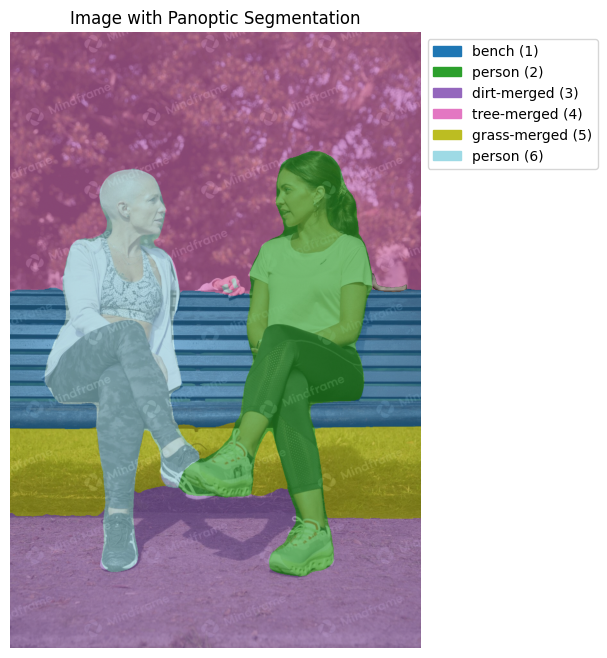

In [ ]:
# Convert the PIL Image to a NumPy array
image_np = np.array(image)

# Convert the panoptic map to NumPy array
panoptic_map_np = predicted_panoptic_map.cpu().numpy()

# Resize the panoptic map to match the original image size
resized_panoptic_map = cv2.resize(
    panoptic_map_np.astype(np.uint8),
    (image_np.shape[1], image_np.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# Extract segment IDs and map to labels
unique_ids = [segment['id'] for segment in result['segments_info']]
id_to_label = {
    segment['id']: model.config.id2label[segment['label_id']]
    for segment in result['segments_info']
}

# Assign colors to each segment ID using a colormap
cmap = plt.cm.get_cmap('tab20', len(unique_ids))
id_to_color = {seg_id: cmap(i) for i, seg_id in enumerate(unique_ids)}

# Create a colored overlay (RGBA)
colored_segmentation = np.zeros((*resized_panoptic_map.shape, 4))
for seg_id, color in id_to_color.items():
    mask = resized_panoptic_map == seg_id
    colored_segmentation[mask] = color  # Apply RGBA color

# Plot the image with overlay
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_np)
ax.imshow(colored_segmentation, alpha=0.6)
ax.axis('off')
ax.set_title("Image with Panoptic Segmentation")

# Build matching legend
legend_patches = [
    mpatches.Patch(color=id_to_color[seg_id], label=f"{id_to_label[seg_id]} ({seg_id})")
    for seg_id in unique_ids
]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
# Extract valid segment IDs from segmentation result
valid_ids = [segment['id'] for segment in result['segments_info']]

# Show valid options to the user before prompting
print(f"Available Segment IDs: {valid_ids}")
for segment in result['segments_info']:
    seg_id = segment['id']
    label_id = segment['label_id']
    label_name = model.config.id2label[label_id]
    print(f"ID {seg_id} → {label_name}")

# Prompt the user for the ID to remove
item_id_to_remove = int(input("Enter the ID of the item to create a mask for: "))

# Validate the input
if item_id_to_remove not in valid_ids:
    raise ValueError(f"Invalid segment ID. Please select one of: {valid_ids}")

Available Segment IDs: [1, 2, 3, 4, 5, 6]
ID 1 → bench
ID 2 → person
ID 3 → dirt-merged
ID 4 → tree-merged
ID 5 → grass-merged
ID 6 → person
Enter the ID of the item to create a mask for: 2


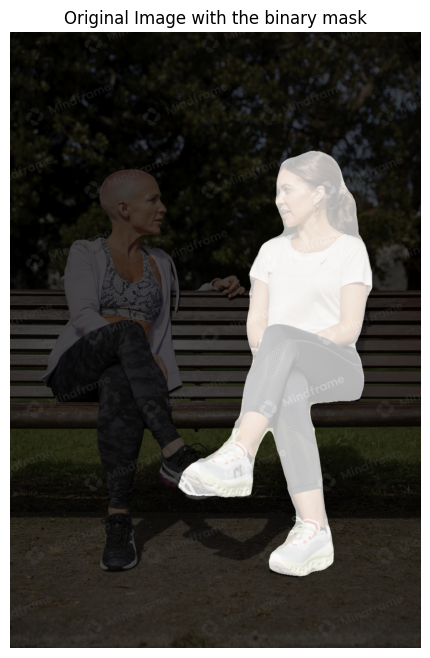

In [ ]:
# Convert the PIL Image to a NumPy array
image_np = np.array(image)

# Convert panoptic_map to NumPy array
panoptic_map_np = predicted_panoptic_map.cpu().numpy()

# Create a binary mask with the specified item colored white
shown_binary_mask = (panoptic_map_np == item_id_to_remove).astype(np.uint8) * 255

# Resize the binary mask to match the original image size
resized_binary_mask = cv2.resize(shown_binary_mask, (image_np.shape[1], image_np.shape[0]))

# Create a new figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the original image
ax.imshow(image_np)
ax.axis('off')
ax.set_title('Original Image with the binary mask')

# Overlay the resized binary mask on top of the original image
ax.imshow(resized_binary_mask, cmap='gray', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = input("Enter the Prompt: ")

Enter the Prompt: replace it with a bear sitting on a bench


In [ ]:
import random

guidance_scale=10
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 9999)) # change the seed to get different results
# generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image.convert("RGB"),
    mask_image = Image.fromarray(resized_binary_mask).convert("RGB"),
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

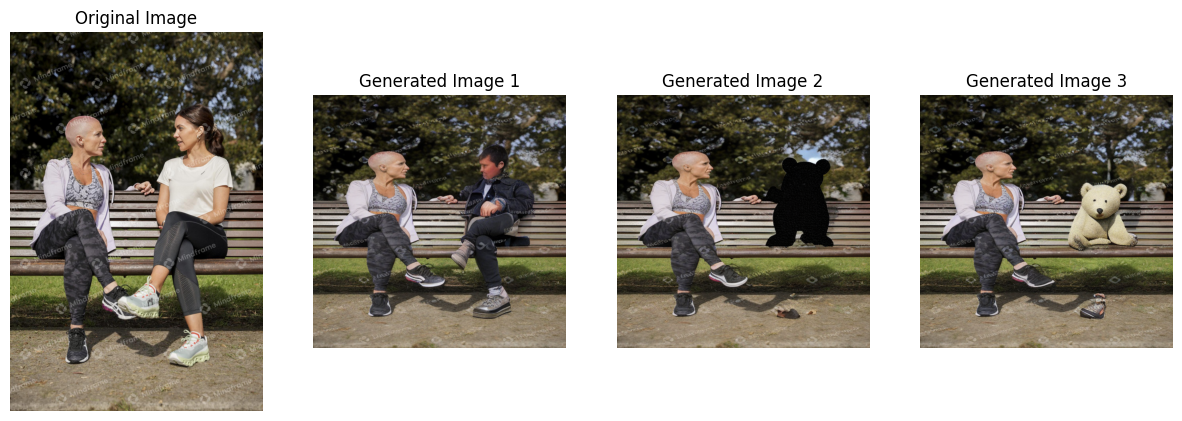

In [ ]:
# Create a figure with subplots
num_samples = len(images) + 1
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_samples, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Plot the generated images
for i in range(len(images)):
    plt.subplot(1, num_samples, i + 2)
    plt.imshow(images[i])
    plt.title(f'Generated Image {i + 1}')
    plt.axis('off')

plt.show()